# 2D Allen–Cahn Equation: Secant Continuation in $\lambda$

This notebook solves the 2D Allen-Cahn equation using a Fourier spectral discretization. The primary technique demonstrated is **secant continuation** in the bifurcation parameter $\lambda$ for a fixed value of $\epsilon$.

The equation is:
$$u_t = \epsilon^2 \Delta u + \lambda u - u^3$$
on the domain $[0,1] \times [0,1]$ with periodic boundary conditions.

### 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftfreq

plt.rcParams.update({"figure.figsize": (8, 6), "image.cmap": "RdBu_r"})

### 2. Set Up Grid and Spectral Operators

In [2]:
def l2_norm(u):
    return np.sqrt(np.mean(np.abs(u)**2))

# Option to switch between periodic and Neumann boundary conditions
use_periodic_bc = True  # Set to False for Neumann BC

Nx = Ny = 64
Lx = Ly = 1.0
x = np.linspace(0, Lx, Nx, endpoint=False)
y = np.linspace(0, Ly, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing="ij")

if use_periodic_bc:
    kx = 2 * np.pi * fftfreq(Nx, d=Lx / Nx)
    ky = 2 * np.pi * fftfreq(Ny, d=Ly / Ny)
    KX, KY = np.meshgrid(kx, ky, indexing="ij")
    lap = -(KX**2 + KY**2)
else:
    # Neumann BC: use cosine basis (DCT) for Laplacian
    from scipy.fft import dctn, idctn
    def dct2(u):
        return dctn(u, type=2, norm='ortho')
    def idct2(u_hat):
        return idctn(u_hat, type=2, norm='ortho')
    kx = np.pi * np.arange(Nx) / Lx
    ky = np.pi * np.arange(Ny) / Ly
    KX, KY = np.meshgrid(kx, ky, indexing="ij")
    lap = -(KX**2 + KY**2)

### 3. Define PDE RHS in Spectral Variables

In [3]:
def rhs_hat(u_hat, epsilon, lam):
    if use_periodic_bc:
        u = np.real(ifft2(u_hat))
        nl_hat = fft2(lam * u - u**3)
        return epsilon**2 * lap * u_hat + nl_hat
    else:
        u = np.real(idct2(u_hat))
        nl_hat = dct2(lam * u - u**3)
        return epsilon**2 * lap * u_hat + nl_hat

### 4. Implement Time-Stepping to Steady State
We use the ETDRK4 (Exponential Time Differencing with 4th-order Runge-Kutta) method for time integration. This is an efficient method for stiff PDEs like the Allen-Cahn equation, as it treats the stiff linear part exactly.

In [4]:
def etdrk4(u0_hat, epsilon, lam, dt=1e-3, tmax=2.0, steady_tol=1e-8, max_steps=20000, check_every=100):
    L = epsilon**2 * lap
    E = np.exp(L * dt)
    E2 = np.exp(L * dt / 2)
    L_safe = L.copy()
    L_safe[L_safe == 0] = 1  # avoid divide-by-zero
    phi1 = (E - 1) / L_safe
    phi2 = (E - 1 - L * dt) / (L_safe**2)
    phi3 = (E - 1 - L * dt - 0.5 * (L * dt) ** 2) / (L_safe**3)

    u_hat = u0_hat.copy()
    if use_periodic_bc:
        prev_u = np.real(ifft2(u_hat))
    else:
        prev_u = np.real(idct2(u_hat))

    for n in range(int(max_steps)):
        Nv = rhs_hat(u_hat, epsilon, lam) - L * u_hat
        a = E2 * u_hat + phi1 * Nv * dt / 2
        Na = rhs_hat(a, epsilon, lam) - L * a
        b = E2 * u_hat + phi1 * Na * dt / 2
        Nb = rhs_hat(b, epsilon, lam) - L * b
        c = E * u_hat + phi1 * (2 * Nb - Nv) * dt
        Nc = rhs_hat(c, epsilon, lam) - L * c
        u_hat = E * u_hat + (phi1 * Nv + 2 * phi2 * (Na + Nb) + phi3 * Nc) * dt

        if n % check_every == 0:
            if use_periodic_bc:
                u = np.real(ifft2(u_hat))
            else:
                u = np.real(idct2(u_hat))
            if l2_norm(u - prev_u) < steady_tol:
                return u_hat, {"steps": n + 1, "converged": True}
            prev_u = u
    return u_hat, {"steps": max_steps, "converged": False}

### 5. Secant Continuation in lambda
This section implements the secant continuation algorithm. It starts with two solutions at nearby $\lambda$ values, then uses a linear extrapolation (the secant) to predict the solution at the next $\lambda$. The time-stepper then corrects this prediction to find the true steady state.

In [5]:
rng = np.random.default_rng(0)

# Use a patterned initial condition for more interesting bifurcation
if use_periodic_bc:
    pattern = 0.3 * np.sin(2 * np.pi * X) * np.sin(2 * np.pi * Y) + 0.1 * rng.standard_normal(size=X.shape)
else:
    # For Neumann BC, use cosine basis pattern
    pattern = 0.3 * np.cos(np.pi * X) * np.cos(np.pi * Y) + 0.1 * rng.standard_normal(size=X.shape)

def run_continuation(epsilon=0.01, lam0=-0.5, lam1=0.0, target=1.5, base_dt=2e-3, max_corr=6.0, max_iters=1000, noise=0.05):
    """Secant predictor + ETDRK4 corrector in lambda."""
    solutions = []
    lam_values = []
    norms = []

    # Start from a nontrivial initial condition
    if use_periodic_bc:
        u0_hat = fft2(pattern)
    else:
        u0_hat = dct2(pattern)
    solutions.append(u0_hat)
    lam_values.append(lam0)
    if use_periodic_bc:
        norms.append(l2_norm(np.real(ifft2(u0_hat))))
    else:
        norms.append(l2_norm(np.real(idct2(u0_hat))))

    u1 = pattern + noise * rng.standard_normal(size=X.shape)
    if use_periodic_bc:
        u1_hat, _ = etdrk4(fft2(u1), epsilon, lam1, dt=base_dt, tmax=max_corr)
        norms.append(l2_norm(np.real(ifft2(u1_hat))))
    else:
        u1_hat, _ = etdrk4(dct2(u1), epsilon, lam1, dt=base_dt, tmax=max_corr)
        norms.append(l2_norm(np.real(idct2(u1_hat))))
    solutions.append(u1_hat)
    lam_values.append(lam1)

    step = 1
    while lam_values[-1] < target - 1e-12 and step < max_iters:
        lam_pred = lam_values[-1] + (lam_values[-1] - lam_values[-2])
        lam_pred = min(lam_pred, target)
        lam_pred = max(lam_pred, lam_values[-1] + 1e-3)

        u_prev, u_curr = solutions[-2], solutions[-1]
        denom = max(lam_values[-1] - lam_values[-2], 1e-6)
        u_guess_hat = u_curr + (lam_pred - lam_values[-1]) * (u_curr - u_prev) / denom
        if use_periodic_bc:
            u_guess_hat = fft2(np.real(ifft2(u_guess_hat)))
        else:
            u_guess_hat = dct2(np.real(idct2(u_guess_hat)))

        u_next_hat, _ = etdrk4(u_guess_hat, epsilon, lam_pred, dt=base_dt, tmax=max_corr)

        solutions.append(u_next_hat)
        lam_values.append(lam_pred)
        if use_periodic_bc:
            norms.append(l2_norm(np.real(ifft2(u_next_hat))))
        else:
            norms.append(l2_norm(np.real(idct2(u_next_hat))))
        step += 1

    return {
        "lambda": np.array(lam_values),
        "solutions": solutions,
        "norms": np.array(norms),
        "final_hat": solutions[-1],
    }

In [6]:
# Configure continuation target and stepper settings
epsilon = 0.05  # smaller epsilon for sharper patterns
start_lambda = -0.2
first_lambda = -0.19   # initial nonzero lambda to seed continuation
target_lambda = 0.2  # extended range for lambda
base_dt = 1e-3
max_corr = 6.0
max_iters = 1000
noise = 1e-3

cont_results = run_continuation(epsilon=epsilon, lam0=start_lambda, lam1=first_lambda, target=target_lambda, base_dt=base_dt, max_corr=max_corr, max_iters=max_iters, noise=noise)
cont_results["lambda"], cont_results["norms"]

(array([-2.00000000e-01, -1.90000000e-01, -1.80000000e-01, -1.70000000e-01,
        -1.60000000e-01, -1.50000000e-01, -1.40000000e-01, -1.30000000e-01,
        -1.20000000e-01, -1.10000000e-01, -1.00000000e-01, -9.00000000e-02,
        -8.00000000e-02, -7.00000000e-02, -6.00000000e-02, -5.00000000e-02,
        -4.00000000e-02, -3.00000000e-02, -2.00000000e-02, -1.00000000e-02,
         1.66533454e-16,  1.00000000e-02,  2.00000000e-02,  3.00000000e-02,
         4.00000000e-02,  5.00000000e-02,  6.00000000e-02,  7.00000000e-02,
         8.00000000e-02,  9.00000000e-02,  1.00000000e-01,  1.10000000e-01,
         1.20000000e-01,  1.30000000e-01,  1.40000000e-01,  1.50000000e-01,
         1.60000000e-01,  1.70000000e-01,  1.80000000e-01,  1.90000000e-01,
         2.00000000e-01]),
 array([0.18066791, 0.00331945, 0.00320598, 0.0015655 , 0.00153449,
        0.00151406, 0.00149492, 0.00147442, 0.00145512, 0.00143485,
        0.00141542, 0.00139527, 0.00137579, 0.0013557 , 0.00133618,
        0

### 6. Visualize Final Steady State and Continuation History

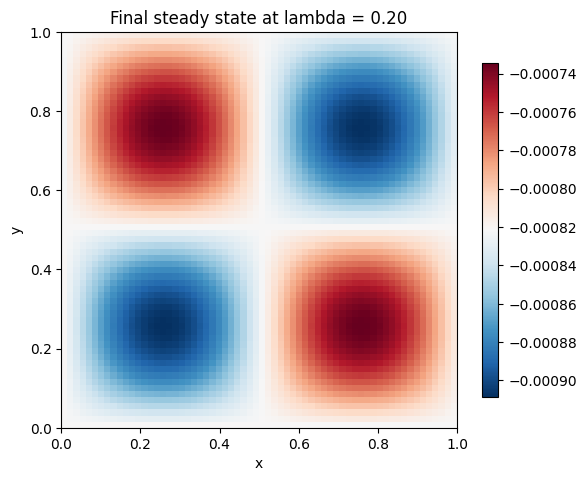

In [7]:
if use_periodic_bc:
    final_u = np.real(ifft2(cont_results["final_hat"]))
else:
    final_u = np.real(idct2(cont_results["final_hat"]))

plt.figure(figsize=(6, 5))
im = plt.imshow(final_u.T, origin="lower", extent=[0, 1, 0, 1])
plt.title("Final steady state at lambda = {:.2f}".format(cont_results["lambda"][-1]))
plt.colorbar(im, shrink=0.8)
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

#### Snapshot plotting
We can also visualize the solution profiles at different values of $\lambda$ along the continuation path to see how the pattern evolves.

/var/folders/mv/gf81txf95873_vgd86v427_r0000gn/T/ipykernel_17597/2244190591.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])


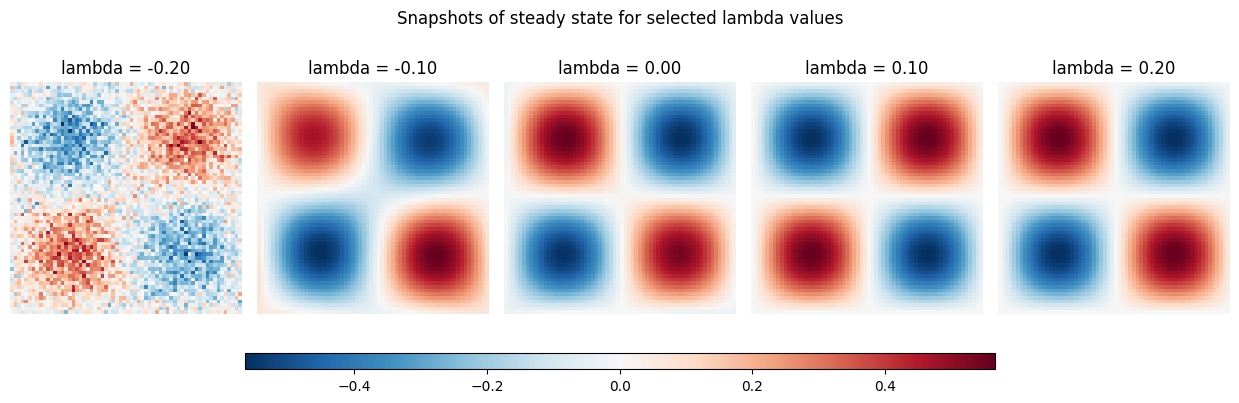

In [8]:
num_snapshots = 5
indices = np.linspace(0, len(cont_results["lambda"]) - 1, num_snapshots, dtype=int)
lambda_vals = cont_results["lambda"][indices]
if use_periodic_bc:
    snapshots = [np.real(ifft2(cont_results["solutions"][i])) for i in indices]
else:
    snapshots = [np.real(idct2(cont_results["solutions"][i])) for i in indices]

fig, axes = plt.subplots(1, num_snapshots, figsize=(2.5 * num_snapshots, 4))
ims = []
for ax, u, lam in zip(axes, snapshots, lambda_vals):
    im = ax.imshow(u.T, origin="lower", extent=[0, 1, 0, 1])
    ims.append(im)
    ax.set_title(f"lambda = {lam:.2f}")
    ax.axis("off")

# Place colorbar below all axes
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.04])
fig.colorbar(ims[0], cax=cbar_ax, orientation='horizontal')
plt.suptitle("Snapshots of steady state for selected lambda values")
plt.tight_layout(rect=[0, 0.15, 1, 0.95])
plt.show()